# Perfilado de Clientes de Zulianita con Clustering (Clients Profiling with Clustering)

Este notebook analiza datos de empleados para identificar perfiles mediante un modelo de K-Means, utilizando variables ampliadas y reducción de dimensionalidad con PCA. El análisis incluye:
- Carga de datos desde Snowflake
- Preprocesamiento de datos con escalamiento y PCA
- Determinación del número óptimo de clusters con el método del codo
- Entrenamiento del modelo K-Means
- Evaluación de resultados con métrica de calidad
- Visualización de clusters y centroides
- Almacenamiento de predicciones y métricas en Snowflake

## 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el análisis, clustering y PCA.

In [ ]:
import pandas as pd
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import pytz
import tempfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import logging
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configurar advertencias y logging
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('customer_segmentation.log')
    ]
)


# Configuración de logging
logging.basicConfig(level=logging.INFO)

## 2. Conexión a Base de Datos y Consulta

Configuramos la conexión a SQL Server y ejecutamos la consulta para obtener los datos de empleados.

In [ ]:
def get_snowflake_connection():
    try:
        conn = snowflake.connector.connect(
            user='XXXXXXXXXXXXXXXX',  
            password='XXXXXXXXXXXXXX',  
            account='XXXXXXXXXXXX', 
            warehouse='XXXXXXXXXXX', 
            database='XXXXXXXXXXX',
            schema='XXXXXXXXXXXX'
        )
        logging.info("Conexión a Snowflake exitosa")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a Snowflake: {e}")
        raise


def load_snowflake_views():
    conn = get_snowflake_connection()
    try:
        df = pd.read_sql("SELECT * FROM VW_CLIENTES_PERFIL", conn)
        return df
    finally:
        conn.close()

# Load data
df = load_snowflake_views()

logging.info(f"Datos cargados: {len(df)} registros")
df.head(10)

2025-06-29 20:03:28,873 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-29 20:03:28,908 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-29 20:03:28,908 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-29 20:03:31,656 - INFO - Conexión a Snowflake exitosa
2025-06-29 20:03:31,656 - INFO - Conexión a Snowflake exitosa
2025-06-29 20:03:35,283 - INFO - Datos cargados: 2000 registros
2025-06-29 20:03:35,283 - INFO - Datos cargados: 2000 registros


,CLIENTE_ID,CIUDAD,TIEMPO_CLIENTE_MESES,DIAS_ULTIMA_COMPRA,TICKETS_TOTALES,PROMEDIO_TICKETS_POR_MES,CANAL_MAS_FRECUENTE,PRODUCTO_MAS_FRECUENTE,CATEGORIA_MAS_FRECUENTE,TOTAL_CANTIDADES,PROMEDIO_CANTIDADES_POR_MES,PROMEDIO_DESCUENTOS_TOTALES,TOTAL_FACTURADO,TOTAL_FACTURADO_PROMEDIO_POR_MES,PROMEDIO_MARGEN_TOTAL,NUMERO_CANALES_DISTINTOS,NUMERO_PRODUCTOS_DISTINTOS,NUMERO_CATEGORIAS_DISTINTAS,FRECUENCIA_COMPRA_DIAS,PORCENTAJE_TRANSACCIONES_CON_DESCUENTO
0,1,Barranquilla,29,32,36,1.565217,Tienda de Conveniencia,Jugo Lima 2000mL x 12uds,Jugo,2709,117.782609,8.611111,1.774627e+08,7.715771e+06,47.763889,5,14,5,24.800000,52.7778
1,2,Villavicencio,29,21,41,1.782609,Supermercado,Jugo Lima 2000mL x 12uds,Jugo,2808,122.086957,8.731707,2.245144e+08,9.761496e+06,48.004878,5,15,5,20.725000,53.6585
2,3,Cúcuta,29,18,37,1.761905,Hipermercado,Agua Sin Gas 1L x 1uds,Agua,2252,107.238095,6.783784,1.515154e+08,7.215018e+06,50.359459,5,15,5,23.638889,43.2432
3,4,Barranquilla,29,16,37,1.761905,Hipermercado,Jugo Manzana 2000mL x 24uds,Jugo,2312,110.095238,9.027027,1.746012e+08,8.314342e+06,47.256757,5,15,5,23.361111,54.0541
4,5,Ibagué,29,18,45,1.875000,E-commerce,Agua con Gas 500mL x 6uds,Agua,3227,134.458333,12.488889,1.739350e+08,7.247291e+06,47.506667,5,13,5,19.295455,64.4444
5,6,Tunja,29,21,46,1.916667,Vending Machine,Power Up 250mL x 6uds,Agua,3019,125.791667,7.000000,1.511105e+08,6.296272e+06,51.397826,5,15,5,17.955556,32.6087
6,7,Cartagena,29,29,37,1.761905,E-commerce,Jugo Manzana 2000mL x 24uds,Agua,2676,127.428571,8.810811,2.346815e+08,1.117531e+07,49.886486,5,13,5,23.527778,45.9459
7,8,Bogotá,29,14,39,1.695652,Vending Machine,Jugo Manzana 2000mL x 24uds,Agua,2523,109.695652,6.435897,1.599466e+08,6.954199e+06,52.241026,5,13,5,22.421053,38.4615
8,9,Cali,29,18,40,1.818182,Tienda de Conveniencia,Agua Sin Gas 1L x 1uds,Agua,2717,123.500000,9.475000,1.568787e+08,7.130850e+06,50.347500,5,13,5,22.333333,55.0000
9,10,Cúcuta,29,15,42,1.826087,Vending Machine,Agua Sin Gas 5L x 12uds,Agua,3053,132.739130,7.357143,2.240979e+08,9.743386e+06,51.371429,5,15,5,19.975610,47.6190


## 3. Preprocesamiento de Datos

Realizamos el preprocesamiento, escalamiento y reducción de dimensionalidad con PCA.

Columnas disponibles en df: ['CLIENTE_ID', 'CIUDAD', 'TIEMPO_CLIENTE_MESES', 'DIAS_ULTIMA_COMPRA', 'TICKETS_TOTALES', 'PROMEDIO_TICKETS_POR_MES', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE', 'CATEGORIA_MAS_FRECUENTE', 'TOTAL_CANTIDADES', 'PROMEDIO_CANTIDADES_POR_MES', 'PROMEDIO_DESCUENTOS_TOTALES', 'TOTAL_FACTURADO', 'TOTAL_FACTURADO_PROMEDIO_POR_MES', 'PROMEDIO_MARGEN_TOTAL', 'NUMERO_CANALES_DISTINTOS', 'NUMERO_PRODUCTOS_DISTINTOS', 'NUMERO_CATEGORIAS_DISTINTAS', 'FRECUENCIA_COMPRA_DIAS', 'PORCENTAJE_TRANSACCIONES_CON_DESCUENTO']
Columnas categóricas disponibles para codificación: ['CIUDAD', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE']
Variables seleccionadas para el modelo:
- TIEMPO_CLIENTE_MESES
- DIAS_ULTIMA_COMPRA
- TICKETS_TOTALES
- PROMEDIO_TICKETS_POR_MES
- TOTAL_CANTIDADES
- PROMEDIO_CANTIDADES_POR_MES
- PROMEDIO_DESCUENTOS_TOTALES
- TOTAL_FACTURADO
- TOTAL_FACTURADO_PROMEDIO_POR_MES
- PROMEDIO_MARGEN_TOTAL
- NUMERO_CANALES_DISTINTOS
- NUMERO_PRODUCTOS_DISTINTOS
- NUME

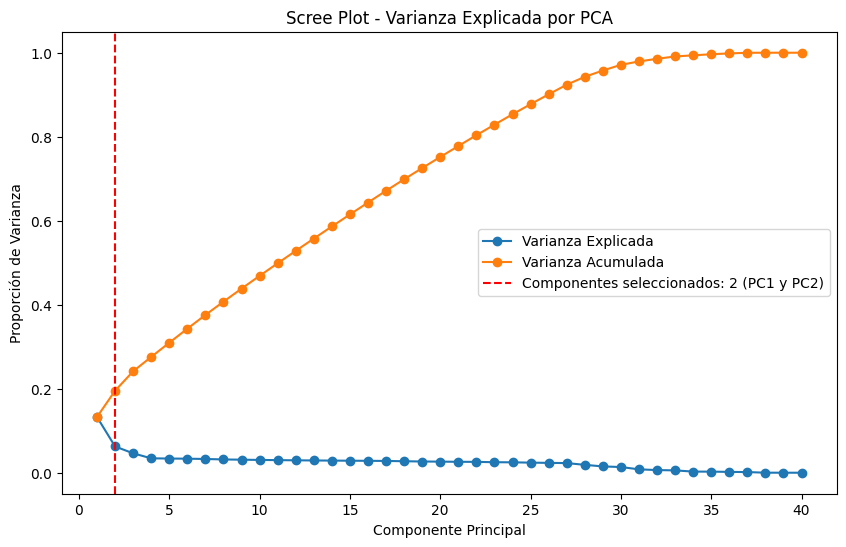

2025-06-29 20:03:36,208 - INFO - Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: 2 (PC1 y PC2)



Contribución de las variables a PC1 y PC2 (Loadings):
                                                              PC1           PC2
TIEMPO_CLIENTE_MESES                                -2.000900e-02 -2.732199e-02
DIAS_ULTIMA_COMPRA                                  -3.992782e-02  6.430498e-02
TICKETS_TOTALES                                      8.952527e-01  9.064445e-04
PROMEDIO_TICKETS_POR_MES                             8.199627e-01 -2.475571e-02
TOTAL_CANTIDADES                                     9.158557e-01 -3.086613e-03
PROMEDIO_CANTIDADES_POR_MES                          8.190981e-01 -2.535034e-02
PROMEDIO_DESCUENTOS_TOTALES                         -6.444691e-02  9.109872e-01
TOTAL_FACTURADO                                      7.894120e-01  6.365114e-02
TOTAL_FACTURADO_PROMEDIO_POR_MES                     6.611978e-01  5.631069e-02
PROMEDIO_MARGEN_TOTAL                               -6.774819e-03 -8.405247e-01
NUMERO_CANALES_DISTINTOS                            -1.505572e-23

In [4]:

# Depuración: Verificar columnas disponibles en el DataFrame
print("Columnas disponibles en df:", df.columns.tolist())

# Definir columnas categóricas esperadas
expected_categorical_columns = ['CIUDAD', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE', 'CATEGORÍA_MAS_FRECUENTE']

# Filtrar solo las columnas categóricas que existen en el DataFrame
available_categorical_columns = [col for col in expected_categorical_columns if col in df.columns]
print("Columnas categóricas disponibles para codificación:", available_categorical_columns)

# Codificación de variables categóricas solo para las columnas disponibles
if available_categorical_columns:
    df = pd.get_dummies(df, columns=available_categorical_columns, drop_first=True)
else:
    print("No se encontraron columnas categóricas para codificar. Revisar la consulta SQL.")

# Selección de características para clustering
features = ['TIEMPO_CLIENTE_MESES', 'DIAS_ULTIMA_COMPRA',
       'TICKETS_TOTALES', 'PROMEDIO_TICKETS_POR_MES', 'TOTAL_CANTIDADES',
       'PROMEDIO_CANTIDADES_POR_MES', 'PROMEDIO_DESCUENTOS_TOTALES',
       'TOTAL_FACTURADO', 'TOTAL_FACTURADO_PROMEDIO_POR_MES',
       'PROMEDIO_MARGEN_TOTAL', 'NUMERO_CANALES_DISTINTOS',
       'NUMERO_PRODUCTOS_DISTINTOS', 'NUMERO_CATEGORIAS_DISTINTAS',
       'FRECUENCIA_COMPRA_DIAS', 'PORCENTAJE_TRANSACCIONES_CON_DESCUENTO'] + \
           [col for col in df.columns if any(prefix in col for prefix in ['CIUDAD_', 'CANAL_MAS_FRECUENTE_', 'PRODUCTO_MAS_FRECUENTE_', 'CATEGORÍA_MAS_FRECUENTE_'])]

# Listar las variables seleccionadas para el modelo
print("Variables seleccionadas para el modelo:")
for feature in features:
    print(f"- {feature}")

X = df[features]

# Estandarización de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Seleccionar solo las dos primeras componentes principales (PC1 y PC2)
n_components = 2
X_pca = X_pca[:, :n_components]

# Mostrar resultados de PCA: Varianza explicada
pca_results = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Varianza Explicada': pca.explained_variance_ratio_,
    'Varianza Acumulada': np.cumsum(pca.explained_variance_ratio_)
})
print("\nResultados de PCA - Varianza Explicada:")
print(pca_results[['Componente', 'Varianza Explicada', 'Varianza Acumulada']].to_string(index=False))

# Graficar la varianza explicada (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', label='Varianza Explicada')
plt.plot(range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', label='Varianza Acumulada')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'Componentes seleccionados: {n_components} (PC1 y PC2)')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza')
plt.title('Scree Plot - Varianza Explicada por PCA')
plt.legend()
plt.show()

# Calcular las cargas (loadings) de PCA para identificar la contribución de las variables
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features
)

# Mostrar las cargas de PC1 y PC2
print("\nContribución de las variables a PC1 y PC2 (Loadings):")
print(loadings[['PC1', 'PC2']].to_string())

# Identificar las variables más influyentes por componente
print("\nVariables más influyentes por Componente Principal:")
for i in range(n_components):
    component = f'PC{i+1}'
    top_vars = loadings[component].abs().sort_values(ascending=False).head(3)
    print(f"\n{component}:")
    for var, value in top_vars.items():
        print(f"- {var}: {value:.3f}")

logging.info(f"Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: {n_components} (PC1 y PC2)")

## 4. Método del Codo para Determinar el Número Óptimo de Clusters

Utilizamos el método del codo para encontrar el número óptimo de clusters, evaluando desde 1 hasta 10 clusters, y renderizamos la gráfica en el notebook.

2025-06-29 20:03:40,679 - INFO - Número óptimo de clusters seleccionado: 9


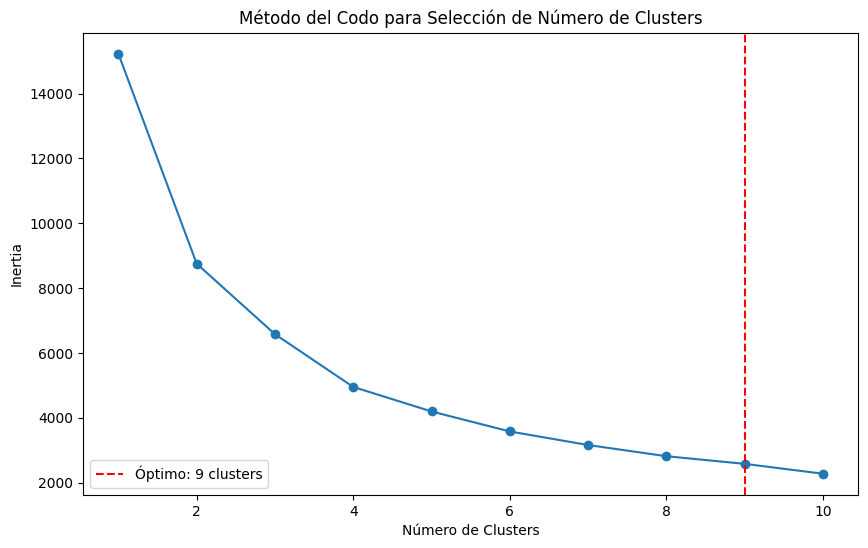

,num_clusters,inertia,silhouette_score,davies_bouldin_score,selected
0,1,15227.177884,0.000000,0.000000,0
1,2,8752.958306,0.367046,1.022717,0
2,3,6578.733080,0.327396,1.024926,0
3,4,4952.271737,0.338855,0.875074,0
4,5,4196.607183,0.319554,0.927017,0
5,6,3579.546850,0.317565,0.914110,0
6,7,3161.642871,0.317366,0.899640,0
7,8,2816.286189,0.312573,0.888946,0
8,9,2580.676837,0.312040,0.900106,1
9,10,2276.349778,0.330977,0.829606,0


In [5]:
# Método del codo
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(X_pca, kmeans.labels_))
    else:
        silhouette_scores.append(0)
        davies_bouldin_scores.append(0)

# Determinar el número óptimo de clusters usando el método del codo
diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmax(diff_r) + 1]
logging.info(f"Número óptimo de clusters seleccionado: {optimal_k}")

# Visualización del método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo para Selección de Número de Clusters')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Óptimo: {optimal_k} clusters')
plt.legend()
plt.show()

# Guardar métricas del codo en la base de datos
elbow_data = pd.DataFrame({
    'num_clusters': k_range,
    'inertia': inertia,
    'silhouette_score': silhouette_scores,
    'davies_bouldin_score': davies_bouldin_scores,
    'selected': [1 if k == optimal_k else 0 for k in k_range]
})

elbow_data

## 5. Entrenamiento del Modelo K-Means

Entrenamos el modelo K-Means con el número óptimo de clusters y evaluamos su calidad.

2025-06-29 20:03:42,033 - INFO - Métricas del modelo: Silhouette Score=0.312, Davies-Bouldin Score=0.900, Mean Squared Distance=1.290, Quality=Aceptable


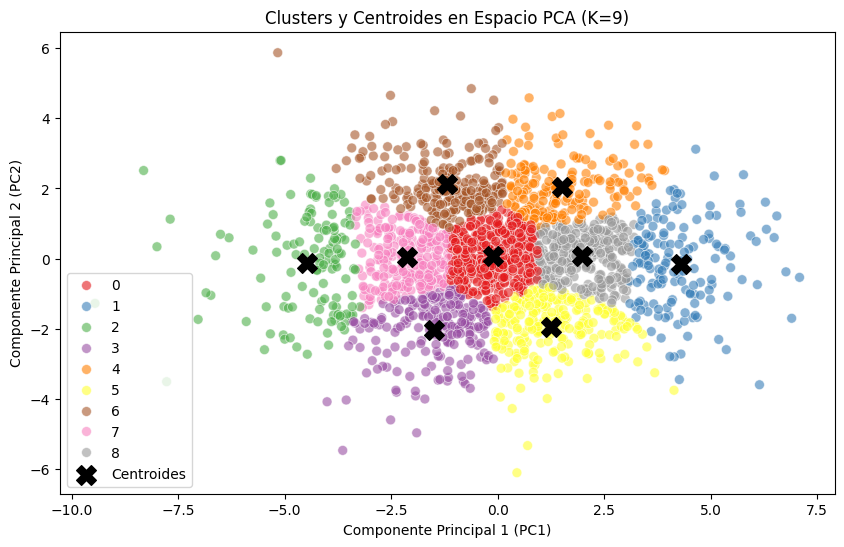

In [6]:
# Entrenar el modelo K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# Asignar etiquetas de cluster a los datos
df['cluster'] = kmeans.labels_

# Calcular métricas del modelo
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
davies_bouldin_avg = davies_bouldin_score(X_pca, kmeans.labels_)
mean_squared_distance = kmeans.inertia_ / len(X_pca)

# Determinar la calidad del modelo
def determine_quality(silhouette, davies_bouldin):
    if silhouette >= 0.5 and davies_bouldin <= 1.0:
        return 'Bueno'
    elif silhouette >= 0.3 and davies_bouldin <= 1.5:
        return 'Aceptable'
    else:
        return 'Pobre'

quality = determine_quality(silhouette_avg, davies_bouldin_avg)

logging.info(f"Métricas del modelo: Silhouette Score={silhouette_avg:.3f}, Davies-Bouldin Score={davies_bouldin_avg:.3f}, Mean Squared Distance={mean_squared_distance:.3f}, Quality={quality}")

# Visualizar clusters y centroides en el espacio de PC1 y PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroides')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title(f'Clusters y Centroides en Espacio PCA (K={optimal_k})')
plt.legend()
plt.show()

## 6. Almacenamiento de Resultados

Guardamos las asignaciones de clusters y las métricas del modelo (incluyendo calidad) en SQL Server.

In [7]:

# Configure logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def create_table_if_not_exists(conn, ddl):
    try:
        with conn.cursor() as cur:
            cur.execute(ddl)
        logging.info(f"Table created or verified successfully")
    except Exception as e:
        logging.error(f"Error creating table: {str(e)}")
        raise

# Get current timestamp in Bogota timezone
timestamp = datetime.datetime.now(pytz.timezone('America/Bogota'))

# 1. Prepare elbow_data for CLUSTERING_ELBOWS_METRICS (append)
elbow_data_to_save = elbow_data.copy()

# Ensure column names are uppercase to match Snowflake's default unquoted identifier behavior
elbow_data_to_save.columns = [col.upper() for col in elbow_data_to_save.columns]
# Explicitly rename columns to match table definition
elbow_data_to_save = elbow_data_to_save.rename(columns={
    'num_clusters': 'NUM_CLUSTERS',
    'inertia': 'INERTIA',
    'silhouette_score': 'SILHOUETTE_SCORE',
    'davies_bouldin_score': 'DAVIES_BOULDIN_SCORE',
    'selected': 'SELECTED'
})
elbow_data_to_save['RUN_TIMESTAMP'] = timestamp

# Debugging: Print DataFrame columns and sample data
logging.info(f"elbow_data_to_save columns: {elbow_data_to_save.columns.tolist()}")
logging.info(f"elbow_data_to_save sample:\n{elbow_data_to_save.head().to_string()}")

elbow_ddl = """
CREATE TABLE IF NOT EXISTS BEBIDAS_PROJECT.BEBIDAS_ANALYTICS.CLUSTERING_ELBOWS_METRICS (
    NUM_CLUSTERS INTEGER,
    INERTIA FLOAT,
    SILHOUETTE_SCORE FLOAT,
    DAVIES_BOULDIN_SCORE FLOAT,
    SELECTED INTEGER,
    RUN_TIMESTAMP TIMESTAMP_TZ
)
"""

# Assume get_snowflake_connection is defined as in the reference notebook
conn = get_snowflake_connection()

# Set schema context
try:
    with conn.cursor() as cur:
        cur.execute("USE SCHEMA BEBIDAS_PROJECT.BEBIDAS_ANALYTICS")
    logging.info("Schema set to BEBIDAS_PROJECT.BEBIDAS_ANALYTICS")
except Exception as e:
    logging.error(f"Error setting schema: {str(e)}")
    raise

create_table_if_not_exists(conn, elbow_ddl)

# Write elbow_data_to_save to Snowflake
try:
    success_elbow, nchunks, nrows, _ = write_pandas(
        conn=conn,
        df=elbow_data_to_save,
        table_name='CLUSTERING_ELBOWS_METRICS',
        database='BEBIDAS_PROJECT',
        schema='BEBIDAS_ANALYTICS',
        auto_create_table=False,
        overwrite=False  # Append mode
    )
    logging.info(f"Exported {nrows} rows to CLUSTERING_ELBOWS_METRICS")
except Exception as e:
    logging.error(f"Error writing to CLUSTERING_ELBOWS_METRICS: {str(e)}")
    raise

# 2. Prepare cluster_results for CLIENTES_CLUSTERS (truncate + insert)
cluster_results = df[['CLIENTE_ID', 'cluster']].copy()

# Ensure column names are uppercase
cluster_results.columns = [col.upper() for col in cluster_results.columns]
cluster_results = cluster_results.rename(columns={
    'CLIENTE_ID': 'CLIENTE_ID',
    'cluster': 'CLUSTER'
})
cluster_results['RUN_TIMESTAMP'] = timestamp

# Debugging: Print DataFrame columns and sample data
logging.info(f"cluster_results columns: {cluster_results.columns.tolist()}")
logging.info(f"cluster_results sample:\n{cluster_results.head().to_string()}")

cluster_ddl = """
CREATE OR REPLACE TABLE BEBIDAS_PROJECT.BEBIDAS_ANALYTICS.CLIENTES_CLUSTERS (
    CLIENTE_ID VARCHAR,
    CLUSTER INTEGER,
    RUN_TIMESTAMP TIMESTAMP_TZ
)
"""
create_table_if_not_exists(conn, cluster_ddl)

# Truncate the table before writing
try:
    with conn.cursor() as cur:
        cur.execute("TRUNCATE TABLE BEBIDAS_PROJECT.BEBIDAS_ANALYTICS.CLIENTES_CLUSTERS")
    logging.info("Table CLIENTES_CLUSTERS truncated")
except Exception as e:
    logging.error(f"Error truncating CLIENTES_CLUSTERS: {str(e)}")
    raise

# Write cluster_results to Snowflake
try:
    success_clusters, nchunks, nrows, _ = write_pandas(
        conn=conn,
        df=cluster_results,
        table_name='CLIENTES_CLUSTERS',
        database='BEBIDAS_PROJECT',
        schema='BEBIDAS_ANALYTICS',
        auto_create_table=False,
        overwrite=False  # Append mode (after truncate)
    )
    logging.info(f"Exported {nrows} rows to CLIENTES_CLUSTERS")
except Exception as e:
    logging.error(f"Error writing to CLIENTES_CLUSTERS: {str(e)}")
    raise

# Verify row counts in Snowflake
try:
    with conn.cursor() as cur:
        cur.execute('SELECT COUNT(*) FROM BEBIDAS_PROJECT.BEBIDAS_ANALYTICS.CLUSTERING_ELBOWS_METRICS')
        count_elbow = cur.fetchone()[0]
        cur.execute('SELECT COUNT(*) FROM BEBIDAS_PROJECT.BEBIDAS_ANALYTICS.CLIENTES_CLUSTERS')
        count_clusters = cur.fetchone()[0]
        logging.info(f"Conteo actual en tablas Snowflake:")
        logging.info(f"- CLUSTERING_ELBOWS_METRICS: {count_elbow}")
        logging.info(f"- CLIENTES_CLUSTERS: {count_clusters}")
except Exception as e:
    logging.error(f"Error verifying row counts: {str(e)}")
    raise

conn.close()
logging.info("Cargado Exitoso: Resultados de clustering y métricas guardados en Snowflake con DDL y write_pandas.")

2025-06-29 20:03:44,789 - INFO - elbow_data_to_save columns: ['NUM_CLUSTERS', 'INERTIA', 'SILHOUETTE_SCORE', 'DAVIES_BOULDIN_SCORE', 'SELECTED', 'RUN_TIMESTAMP']
2025-06-29 20:03:44,799 - INFO - elbow_data_to_save sample:
   NUM_CLUSTERS       INERTIA  SILHOUETTE_SCORE  DAVIES_BOULDIN_SCORE  SELECTED                    RUN_TIMESTAMP
0             1  15227.177884          0.000000              0.000000         0 2025-06-29 20:03:44.610466-05:00
1             2   8752.958306          0.367046              1.022717         0 2025-06-29 20:03:44.610466-05:00
2             3   6578.733080          0.327396              1.024926         0 2025-06-29 20:03:44.610466-05:00
3             4   4952.271737          0.338855              0.875074         0 2025-06-29 20:03:44.610466-05:00
4             5   4196.607183          0.319554              0.927017         0 2025-06-29 20:03:44.610466-05:00
2025-06-29 20:03:44,799 - INFO - elbow_data_to_save sample:
   NUM_CLUSTERS       INERTIA  SILHOUETT

## 7. Visualización de Resultados

Visualizamos las características promedio por cluster y los clusters con sus centroides en el espacio de PCA.

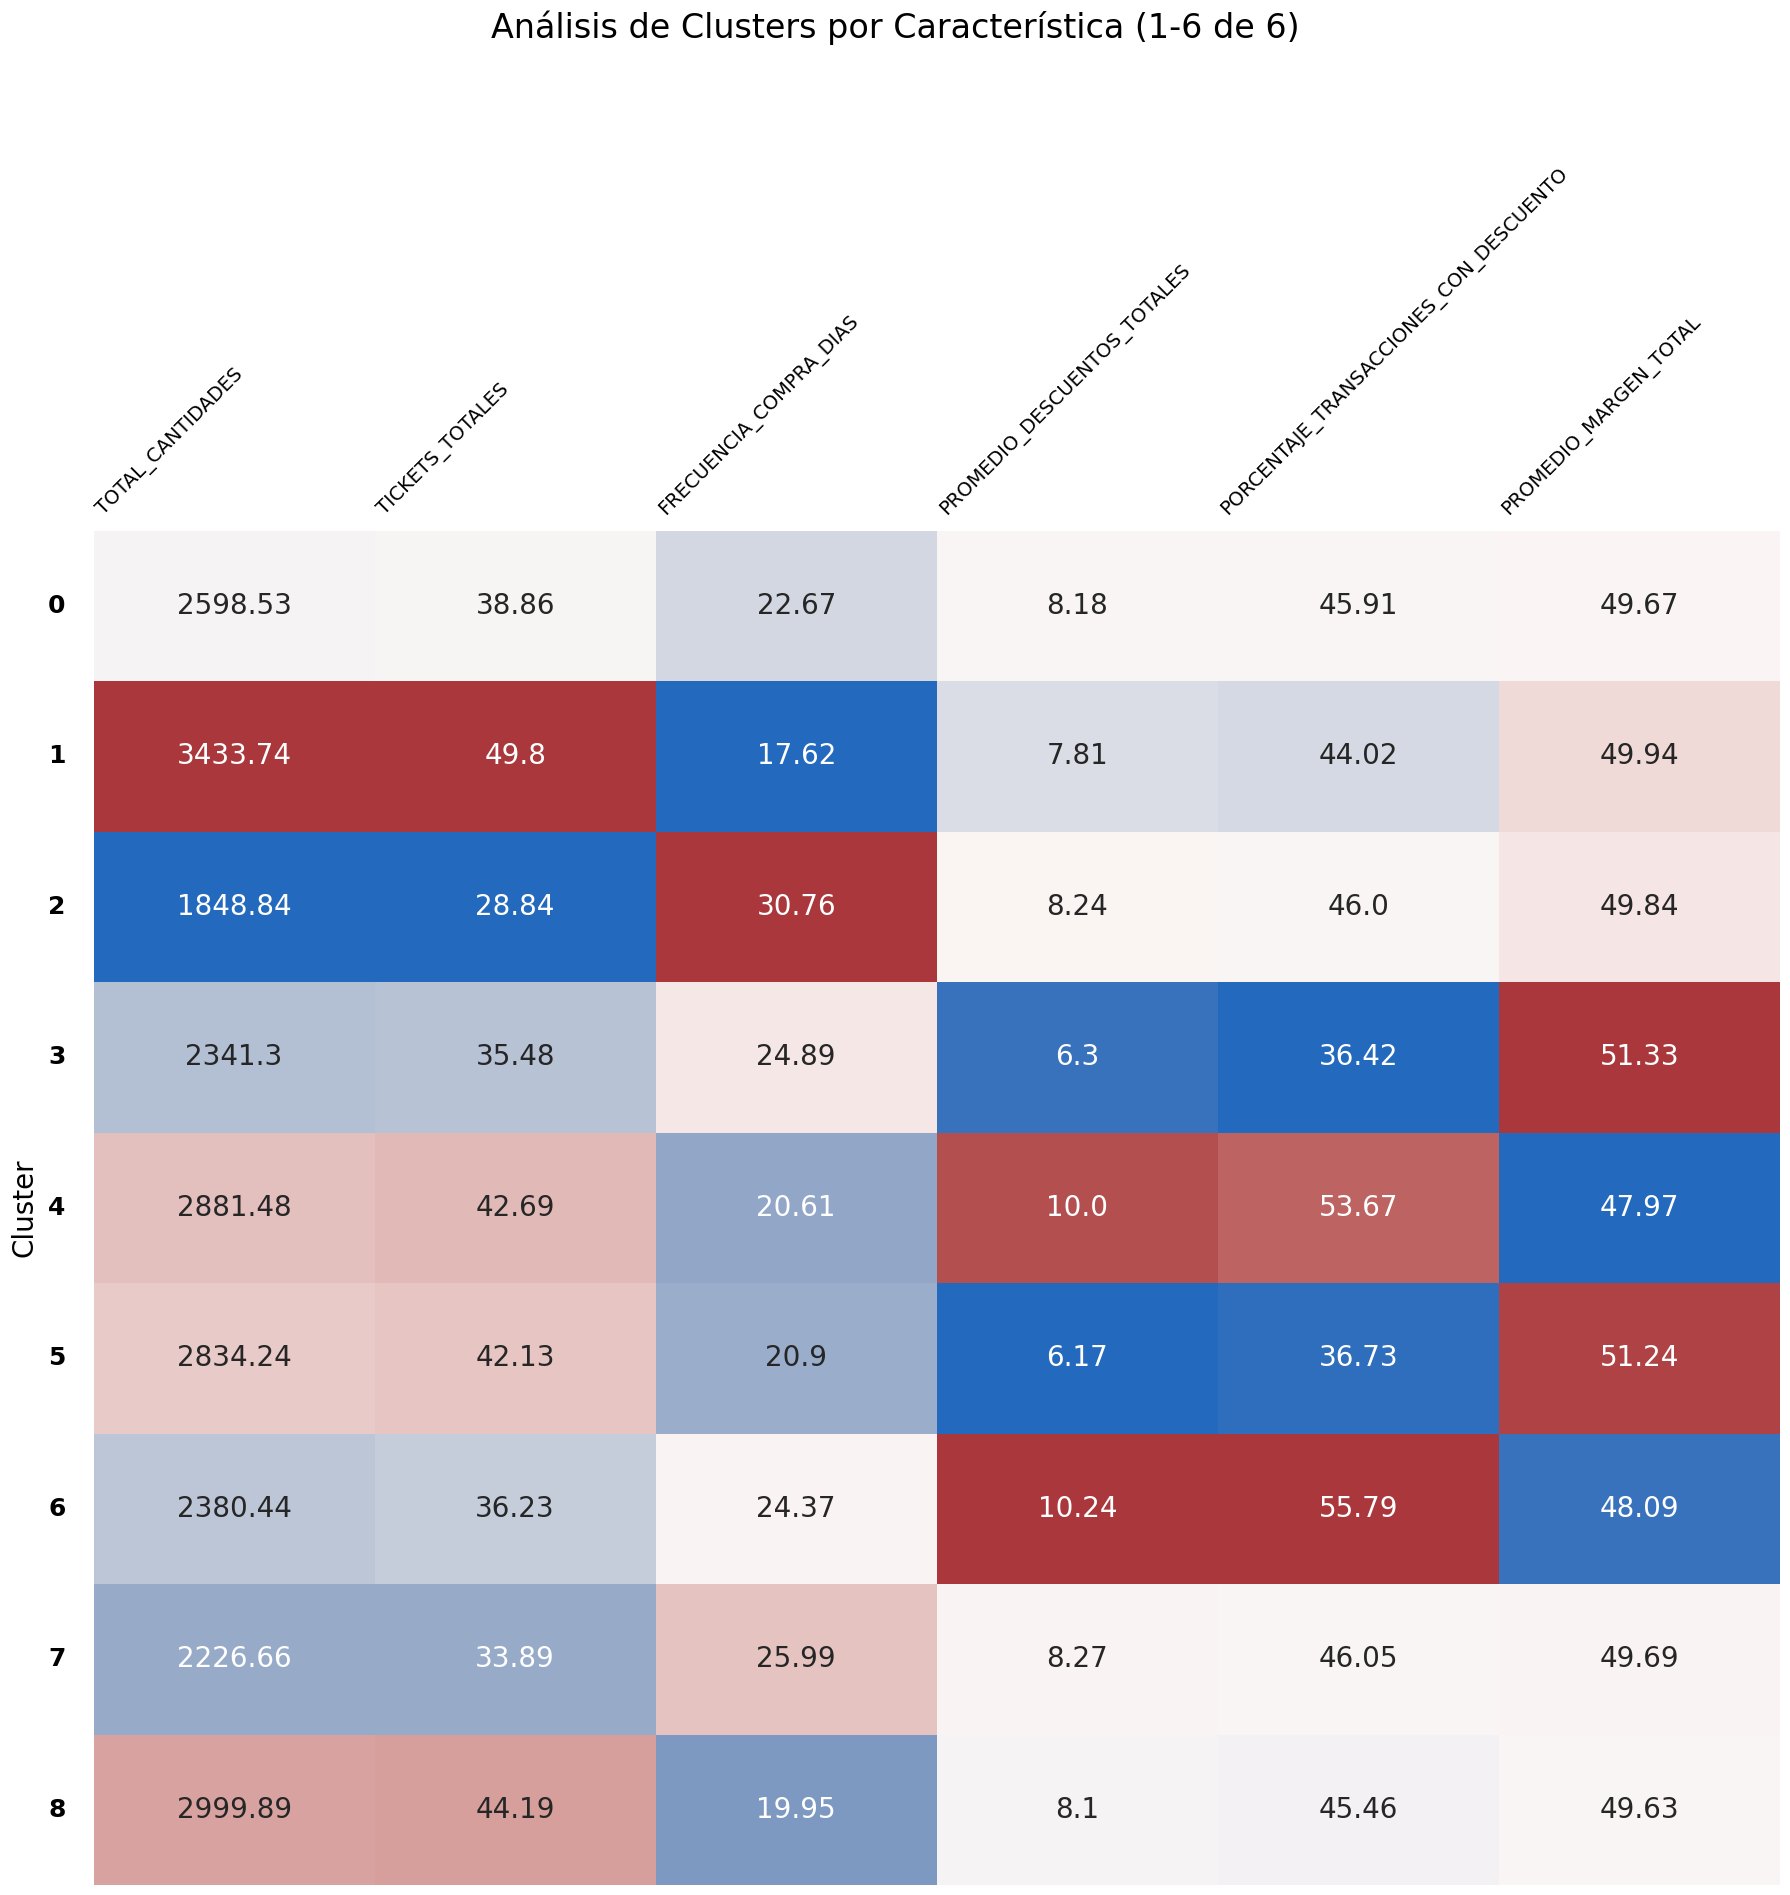

In [8]:
# Selecciona solo las variables más influyentes en PC1 y PC2 para el resumen

# Obtener las top 3 variables de cada componente principal (PC1 y PC2)
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(3).index.tolist()
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(3).index.tolist()
# Unir y quitar duplicados
selected_vars = list(dict.fromkeys(top_pc1 + top_pc2))

# Asegurarse de que las variables existen en el DataFrame
selected_vars = [col for col in selected_vars if col in df.columns]

cluster_summary = df.groupby('cluster')[selected_vars].mean()

column_settings = {col: {'cmap': 'vlag', 'direction': 1} for col in selected_vars}

# Visualización de clusters por característica (encabezados inclinados arriba)
import math

n_cols = len(cluster_summary.columns)
n_rows = len(cluster_summary)

max_cols_per_fig = 10  # Máximo de columnas por figura para legibilidad
num_figs = math.ceil(n_cols / max_cols_per_fig)

for i in range(num_figs):
    start = i * max_cols_per_fig
    end = min((i + 1) * max_cols_per_fig, n_cols)
    cols = cluster_summary.columns[start:end]
    fig, axs = plt.subplots(1, len(cols),
                           figsize=(3*len(cols), 2*n_rows),
                           sharey=True,
                           gridspec_kw={'wspace': 0})  # Sin separación horizontal
    if len(cols) == 1:
        axs = [axs]
    for j, (ax, colname) in enumerate(zip(axs, cols)):
        col_data = cluster_summary[[colname]]
        # Normalización
        norm_data = (col_data - col_data.min()) / (col_data.max() - col_data.min())
        sns.heatmap(norm_data,
                    annot=col_data.round(2),
                    fmt='',
                    cmap='vlag',
                    cbar=False,
                    ax=ax,
                    linewidths=0,  # Sin líneas entre celdas
                    vmin=0,
                    vmax=1,
                    annot_kws={"size": 20},
                    yticklabels=(j == 0),  # Solo el más externo muestra etiquetas
                    xticklabels=True)
        # Inclinación del título de la columna (encabezado superior)
        ax.set_title(colname, pad=12, fontsize=14, rotation=45, loc='left')
        ax.set_xlabel('')
        ax.set_xticks([])
        if j != 0:
            ax.set_ylabel('')
            ax.set_yticks([])
        else:

            ax.set_ylabel('Cluster', fontsize=20, labelpad=40)
            ax.set_yticks(range(len(cluster_summary.index)))
            ax.set_yticklabels(['']*len(cluster_summary.index), fontsize=14)  
            # Alinear los números de cluster con las filas del heatmap (de arriba hacia abajo)
            cluster_ids = list(cluster_summary.index)
            if hasattr(ax, 'get_ylim') and ax.get_ylim()[0] > ax.get_ylim()[1]:
                # Si el heatmap está invertido, invertir el orden de los clusters
                cluster_ids = cluster_ids[::-1]
            for y, cluster_id in enumerate(cluster_ids):
                ax.annotate(str(cluster_id), xy=(-0.10, (y+0.5)/n_rows), xycoords=ax.transAxes, fontsize=18, ha='right', va='center', color='black', fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.95))
    fig.suptitle(f'Análisis de Clusters por Característica ({start+1}-{end} de {n_cols})', y=1.05, fontsize=24)
    plt.tight_layout()
    plt.show()


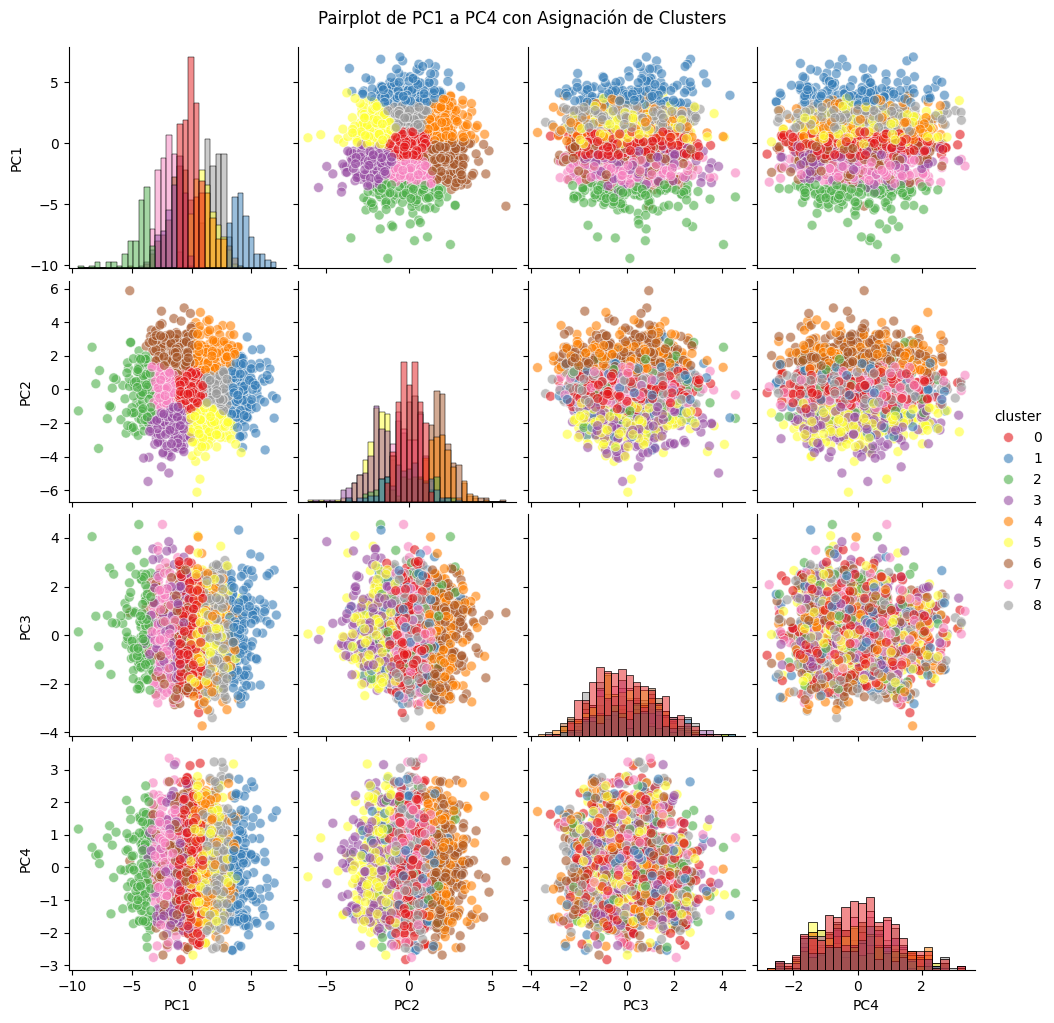

2025-06-29 20:04:32,968 - INFO - Visualización de perfiles de clusters, gráfico PCA y pairplot generados.


In [9]:

# Preparar datos para pairplot con PC1 a PC4
X_pca_extended = pca.transform(X_scaled)[:, :4]  # Tomar PC1, PC2, PC3, PC4
pca_df = pd.DataFrame(X_pca_extended, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['cluster'] = df['cluster']

sns.pairplot(pca_df, hue='cluster', palette='Set1', diag_kind='hist', plot_kws={'alpha': 0.6, 's': 50})
plt.suptitle('Pairplot de PC1 a PC4 con Asignación de Clusters', y=1.02)
plt.show()

logging.info("Visualización de perfiles de clusters, gráfico PCA y pairplot generados.")


In [16]:

X_pca_3d = pca.transform(X_scaled)[:, :3]
cluster_labels = df['cluster']

fig = px.scatter_3d(
    x=X_pca_3d[:, 0],
    y=X_pca_3d[:, 1],
    z=X_pca_3d[:, 2],
    color=cluster_labels.astype(str),
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3', 'color': 'Cluster'},
    title=f'Visualización 3D Interactiva de {optimal_k} Clusters (PC1, PC2, PC3)',
    height=900  # Aumenta la altura del gráfico
)
fig.show()

## 8. Notificación a Discord

In [10]:
import requests
import datetime

# Notificación a Discord usando la función SQL en Snowflake
# Obtener las variables top de PC1 y PC2 para el mensaje
pc1_vars = ', '.join(top_pc1)
pc2_vars = ', '.join(top_pc2)

try:
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    # Conteo total en tablas
    cursor.execute('SELECT COUNT(*) FROM CLUSTERING_ELBOWS_METRICS')
    count_elbows_total = cursor.fetchone()[0]
    cursor.execute('SELECT COUNT(*) FROM CLIENTES_CLUSTERS')
    count_clusters_total = cursor.fetchone()[0]
    # Registros cargados en esta corrida
    enviados_elbows = len(elbow_data_to_save)
    enviados_clusters = len(cluster_results)
    # Llamar función SQL para enviar mensaje a Discord
    sql = f"""
        SELECT send_discord_webhook_clustering(
            {optimal_k},
            {silhouette_avg},
            {davies_bouldin_avg},
            '{quality}',
            '{pc1_vars}',
            '{pc2_vars}',
            {enviados_elbows},
            {enviados_clusters},
            {count_elbows_total},
            {count_clusters_total},
            TRUE
        )
    """
    cursor.execute(sql)
    result = cursor.fetchone()[0]
    print(result)
    cursor.close()
    conn.close()
except Exception as e:
    print(f"Error al enviar notificación a Discord desde Snowflake: {e}")

2025-06-29 20:04:33,286 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-29 20:04:33,289 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-29 20:04:33,289 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-29 20:04:34,252 - INFO - Conexión a Snowflake exitosa
2025-06-29 20:04:34,252 - INFO - Conexión a Snowflake exitosa


Mensaje enviado a Discord.
